In [1]:
//==================================================================================================
// Written in 2016 by Peter Shirley <ptrshrl@gmail.com>
//
// To the extent possible under law, the author(s) have dedicated all copyright and related and
// neighboring rights to this software to the public domain worldwide. This software is distributed
// without any warranty.
//
// You should have received a copy (see file COPYING.txt) of the CC0 Public Domain Dedication along
// with this software. If not, see <http://creativecommons.org/publicdomain/zero/1.0/>.
//==================================================================================================
#include <lodepng_config_cling.h>
#include <iostream>
#include "sphere.h"
#include "moving_sphere.h"
#include "hitable_list.h"
#include "float.h"
#include "camera.h"
#include "material.h"
#include "bvh.h"
#include "box.h"
#include "surface_texture.h"
#include "aarect.h"
#include "texture.h"
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#include "pdf.h"

inline vec3 de_nan(const vec3& c) {
    vec3 temp = c;
    if (!(temp[0] == temp[0])) temp[0] = 0;
    if (!(temp[1] == temp[1])) temp[1] = 0;
    if (!(temp[2] == temp[2])) temp[2] = 0;
    return temp;
}



In [3]:
vec3 color(const ray& r, hitable *world, hitable *light_shape, int depth) {
    hit_record hrec;
    if (world->hit(r, 0.001, MAXFLOAT, hrec)) {
        scatter_record srec;
        vec3 emitted = hrec.mat_ptr->emitted(r, hrec, hrec.u, hrec.v, hrec.p);
        if (depth < 50 && hrec.mat_ptr->scatter(r, hrec, srec)) {
            if (srec.is_specular) {
                return srec.attenuation * color(srec.specular_ray, world, light_shape, depth+1);
            }
            else {
                hitable_pdf plight(light_shape, hrec.p);
                mixture_pdf p(&plight, srec.pdf_ptr.get());
                ray scattered = ray(hrec.p, p.generate(), r.time());
                float pdf_val = p.value(scattered.direction());
                return emitted + srec.attenuation*hrec.mat_ptr->scattering_pdf(r, hrec, scattered)*color(scattered, world, light_shape, depth+1) / pdf_val;
            }
        }
        else
            return emitted;
    }
    else
        return vec3(0,0,0);
}



In [4]:
void cornell_box(hitable **scene, camera **cam, float aspect) {
    int i = 0;
    hitable **list = new hitable*[8];
    material *red = new lambertian( new constant_texture(vec3(0.65, 0.05, 0.05)) );
    material *white = new lambertian( new constant_texture(vec3(0.73, 0.73, 0.73)) );
    material *green = new lambertian( new constant_texture(vec3(0.12, 0.45, 0.15)) );
    material *light = new diffuse_light( new constant_texture(vec3(15, 15, 15)) );
    list[i++] = new flip_normals(new yz_rect(0, 555, 0, 555, 555, green));
    list[i++] = new yz_rect(0, 555, 0, 555, 0, red);
    list[i++] = new flip_normals(new xz_rect(213, 343, 227, 332, 554, light));
    list[i++] = new flip_normals(new xz_rect(0, 555, 0, 555, 555, white));
    list[i++] = new xz_rect(0, 555, 0, 555, 0, white);
    list[i++] = new flip_normals(new xy_rect(0, 555, 0, 555, 555, white));
    material *glass = new dielectric(1.5);
    list[i++] = new sphere(vec3(190, 90, 190),90 , glass);
    list[i++] = new translate(new rotate_y(
                    new box(vec3(0, 0, 0), vec3(165, 330, 165), white),  15), vec3(265,0,295));
    *scene = new hitable_list(list,i);
    vec3 lookfrom(278, 278, -800);
    vec3 lookat(278,278,0);
    float dist_to_focus = 10.0;
    float aperture = 0.0;
    float vfov = 40.0;
    *cam = new camera(lookfrom, lookat, vec3(0,1,0),
                      vfov, aspect, aperture, dist_to_focus, 0.0, 1.0);
}


In [5]:
template <typename T, std::size_t ... Is>
constexpr auto gft_helper (std::index_sequence<Is...> const &)
   -> decltype(std::make_tuple( ((void)Is, std::declval<T>())... ));

template <typename T, std::size_t N>
constexpr auto get_fixed_tuple ()
  -> decltype(gft_helper<T>(std::make_index_sequence<N>{}));

template <typename T, std::size_t N>
using tuple_fixed_type = decltype(get_fixed_tuple<T, N>());

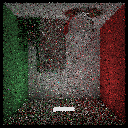

In [6]:
#include <lodepng.h>
#include <xcpp/xdisplay.hpp>
#include <JSONPNGConvert.h>

[](){
auto try_and_err = [](){

constexpr int nx = 128;
constexpr int ny = 128;
constexpr int ns = 10;
//std::cout << "P3\n" << nx << " " << ny << "\n255\n";
hitable *world;
camera *cam;
constexpr float aspect = float(ny) / float(nx);
cornell_box(&world, &cam, aspect);
hitable *light_shape = new xz_rect(213, 343, 227, 332, 554, 0);
hitable *glass_sphere = new sphere(vec3(190, 90, 190), 90, 0);
hitable *a[2];
a[0] = light_shape;
a[1] = glass_sphere;
hitable_list hlist(a,2);
    
auto ray_tup = tuple_fixed_type<ray, ns>{};
std::vector<decltype(ray_tup)> rays(nx*ny);
    
    
for (int j = ny-1; j >= 0; j--) {
    for (int i = 0; i < nx; i++) {
        for (int s=0; s < ns; s++) {            
            float u = float(i+drand48())/ float(nx);
            float v = float(j+drand48())/ float(ny);
            std::apply([&](auto&&... r) {
                ((r = cam->get_ray(u,v)), ...); }, ray_tup);
                       
        }
        rays[j*nx + i] = ray_tup;
    }
}
std::vector<vec3> cols;
cols.reserve(nx*ny);
for (auto &r_tup: rays){
    //vec3 p = r.point_at_parameter(2.0);
    vec3 col(0,0,0);
    std::apply([&](auto&&... r) {
               ((col += de_nan(color(r, world, &hlist, 0))), ...); },
           r_tup);
    cols.push_back(col);
}

std::vector<std::uint8_t> ImageBuffer;
ImageBuffer.reserve(nx*ny*4);
    
for (auto &col: cols){
    col /= float(ns);
    col = vec3( sqrt(col[0]), sqrt(col[1]), sqrt(col[2]) );
    int ir = int(255.99*col[0]);
    int ig = int(255.99*col[1]);
    int ib = int(255.99*col[2]);
    ImageBuffer.push_back(ir);
    ImageBuffer.push_back(ig);
    ImageBuffer.push_back(ib);
    ImageBuffer.push_back(255);
}

std::vector<std::uint8_t> PngBuffer;
lodepng::encode(PngBuffer, ImageBuffer, nx, ny);        
xcpp::display(im::image(PngBuffer));
};
try_and_err();
}();
